In [19]:
import librosa
import pyaudio
import queue
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime

SAMPLE_RATE = 22050
HOP_LENGTH = 256
CHANNELS = 1
N_FFT = 512

In [27]:
class StreamProcessor:
    def __init__(self, sample_rate=SAMPLE_RATE, chunk_size=2048):
        self.chunk_size = chunk_size
        self.channels = CHANNELS
        self.sample_rate = sample_rate
        self.format = pyaudio.paFloat32
        self.audio_interface: Optional[pyaudio.PyAudio] = None
        self.audio_stream: Optional[pyaudio.Stream] = None
        self.buffer = queue.Queue()
        self.chroma_buffer = queue.Queue()
        self.last_chunk = None
        self.is_mic_open = False
        self.index = 0

    def _process_frame(self, data, frame_count, time_into, status_flag):
        print(f"{self.index}st frame has arrived: {time.time()}")

        self.buffer.put(data)

        query_audio = np.frombuffer(data, dtype=np.float32)
        query_chroma_stft = librosa.feature.chroma_stft(
            y=query_audio, hop_length=HOP_LENGTH, n_fft=N_FFT
        )
        if self.last_chunk is None:  # first audio chunk is given
            self.chroma_buffer.put(query_chroma_stft[:, :-1])  # pop last frame converted with zero padding
        else:
            override_previous_padding = librosa.feature.chroma_stft(
                y=np.concatenate((self.last_chunk, query_audio[:HOP_LENGTH])),
                hop_length=HOP_LENGTH,
                n_fft=N_FFT,
            )[:, 1:-1]  # drop first and last frame converted with zero padding
            accumulated_chroma = np.concatenate((override_previous_padding, query_chroma_stft[:, 1:-1]), axis=1)
            self.chroma_buffer.put(accumulated_chroma)
        
        self.last_chunk = query_audio[query_audio.shape[0] - HOP_LENGTH:]
        self.index += 1
        return (data, pyaudio.paContinue)

    def run(self):
        self.audio_interface = pyaudio.PyAudio()
        self.audio_stream = self.audio_interface.open(
            format=self.format,
            channels=self.channels,
            rate=self.sample_rate,
            input=True,
            frames_per_buffer=self.chunk_size,
            stream_callback=self._process_frame,
        )
        self.is_mic_open = True
        self.audio_stream.start_stream()
        print("* Recording in progress....")

    def stop(self):
        if self.is_mic_open:
            self.audio_stream.stop_stream()
            self.audio_stream.close()
            self.is_mic_open = False
            self.audio_interface.terminate()
            print("Recording Stopped.")

In [15]:
# synctoolbox test -> 다음 기회에...

from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw
from synctoolbox.dtw.cost import cosine_distance, euclidean_distance
from synctoolbox.dtw.core import compute_warping_path
from libfmp.c3.c3s2_dtw_plot import plot_matrix_with_points

RECORD_SECONDS = 15
CHUNK_SIZE = 2048

chunks = np.array([])
query_chroma_stft = np.array([])

ref_audio, ref_sr = librosa.load("../resources/audio/target/Happy_Birthday_To_You_C_Major.wav")
ref_chroma_stft = librosa.feature.chroma_stft(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
cost_matrix = None
step_index_matrix = None
warping_path = None

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
for _ in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
    chroma_stft = sp.chroma_buffer.get()  # (12, 8)
    
    query_chroma_stft = np.concatenate((query_chroma_stft, chroma_stft), axis=1) if query_chroma_stft.any() else chroma_stft
    query_pointer = query_chroma_stft.shape[1]
    D, wp = librosa.sequence.dtw(
        X=ref_chroma_stft[:, :query_pointer],
        Y=query_chroma_stft,
        global_constraints=True,
        subseq=True,
    )
    # C = euclidean_distance(ref_chroma_stft[:, :query_pointer], query_chroma_stft)
    # D, E, wp = compute_warping_path(C=C)
    cost_matrix = D
    warping_path = wp

end = time.time()
sp.stop()
duration = end - start
print(f"duration: {duration}")

plt.plot(warping_path[:, 0], warping_path[:, 1])
plt.show()

array([[1287, 1232],
       [1286, 1232],
       [1285, 1232],
       ...,
       [   2,  159],
       [   1,  159],
       [   0,  158]])

* Recording in progress....
0st frame has arrived: 1647194329.699153
get 0st frame 1647194329.7013981
after computating 0st frame: 1647194329.702044

1st frame has arrived: 1647194329.792468
get 1st frame 1647194329.796701
after computating 1st frame: 1647194329.797069

2st frame has arrived: 1647194329.8859599
get 2st frame 1647194329.890922
after computating 2st frame: 1647194329.891408

3st frame has arrived: 1647194329.978297
get 3st frame 1647194329.9827
after computating 3st frame: 1647194329.983191

4st frame has arrived: 1647194330.071316
get 4st frame 1647194330.075335
after computating 4st frame: 1647194330.075994

5st frame has arrived: 1647194330.164195
get 5st frame 1647194330.168733
after computating 5st frame: 1647194330.16929

6st frame has arrived: 1647194330.256584
get 6st frame 1647194330.26044
after computating 6st frame: 1647194330.26103

7st frame has arrived: 1647194330.350317
get 7st frame 1647194330.355329
after computating 7st frame: 1647194330.356525

8st fra

/Users/june/.pyenv/versions/miniforge3-4.10.1-5/envs/imp/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


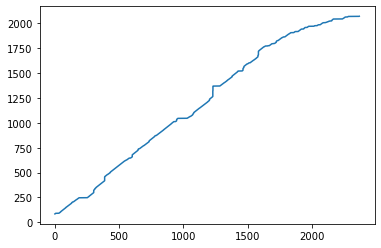

In [36]:
# librosa test

RECORD_SECONDS = 30
CHUNK_SIZE = 2048

chunks = np.array([])
query_chroma_stft = np.array([])

ref_audio, ref_sr = librosa.load("../resources/audio/target/Happy_Birthday_To_You_C_Major.wav")
ref_chroma_stft = librosa.feature.chroma_stft(y=ref_audio, sr=ref_sr, hop_length=HOP_LENGTH, n_fft=N_FFT)
cost_matrix = None
step_index_matrix = None
warping_path = None

sp = StreamProcessor(SAMPLE_RATE, CHUNK_SIZE)
sp.run()

start = time.time()
for i in range(int(SAMPLE_RATE / CHUNK_SIZE * RECORD_SECONDS)):
    chroma_stft = sp.chroma_buffer.get()  # (12, 8)
    print(f"get {i}st frame {time.time()}")
    
    query_chroma_stft = np.concatenate((query_chroma_stft, chroma_stft), axis=1) if query_chroma_stft.any() else chroma_stft
    query_pointer = query_chroma_stft.shape[1]
    D, wp = librosa.sequence.dtw(
        X=ref_chroma_stft[:, :query_pointer],
        Y=query_chroma_stft,
        global_constraints=True,
        subseq=True,
    )
    cost_matrix = D
    warping_path = wp

    print(f"after computating {i}st frame: {time.time()}\n")


end = time.time()
sp.stop()
duration = end - start
print(f"duration: {duration}")

plt.plot(warping_path[:, 0], warping_path[:, 1])
plt.show()

In [35]:
warping_path

array([[1287, 1153],
       [1286, 1153],
       [1285, 1153],
       ...,
       [   2,   98],
       [   1,   97],
       [   0,   96]])